In [4]:
''' Module Import '''
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as img
import os, copy, shutil, cv2
from PIL import Image
from scipy.spatial import distance
import xml.etree.ElementTree as ET

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torchvision.models as models
import rexnetv1

from utils.utils import Utils
# 함수 클래스 인스턴스화
ut = Utils()

# AI 모델 불러오기

### GPU 모드 설정

In [5]:
''' 딥러닝 모델을 설계할 때 활요하는 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.11.0+cu113  Device: cuda


### Hyperparameter 설정

In [6]:
BATCH_SIZE = 1
EPOCHS = 10
LEARNING_RATE = 0.0005
OPTIM = 'SGD' # Adam
MODEL = 'AlexNet' # AlexNet ResNet101 ResNet50 ResNet34 ResNet18 RexNet
NUM_CLASS = 2
PRETRAINED = True

### Preprocessing 정의

In [7]:
data_transforms = {
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])
    ])
}

### 모델 불러오기

In [8]:
if MODEL == 'AlexNet':
    model = models.alexnet(pretrained=PRETRAINED)
    model._modules['classifier']._modules['6'] = nn.Linear(4096, NUM_CLASS, bias=True)
elif MODEL == 'ResNet18':
    model = models.resnet18(pretrained=PRETRAINED)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, NUM_CLASS)
elif MODEL == 'ResNet34':
    model = models.resnet34(pretrained=PRETRAINED)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, NUM_CLASS)
elif MODEL == 'ResNet50':
    model = models.resnet50(pretrained=PRETRAINED)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, NUM_CLASS)
elif MODEL == 'ResNet101':
    model = models.resnet101(pretrained=PRETRAINED)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, NUM_CLASS)
elif MODEL == 'RexNet': # BATCH_SIZE 1은 에러남
    model = rexnetv1.ReXNetV1(width_mult=1.0).cuda()
    if PRETRAINED:
        model.load_state_dict(torch.load('./rexnetv1_1.0.pth'))

init_model = copy.deepcopy(model)
print(init_model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [9]:
# Best 모델 파라미터 불러오기
BEST_MODEL_PATH = './saved_model/AlexNet_Pretrained_BS1_SGD_LR0005_EP10_TR-Custom_Paper-fold12345_all_VD-Additional-total_20221028+empty_generated_overlap_removed_valid.pt'

# 모델 초기화 
model = copy.deepcopy(init_model)
model = model.cuda()

# Optimizer 및 loss 정의
if OPTIM == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
elif OPTIM == 'SGD':
    optimizer = torch.optim.SGD(model.parameters(), lr = LEARNING_RATE, momentum=0.9, weight_decay=0.0005)
criterion = nn.CrossEntropyLoss()

# 사전에 훈련된 모델이 존재하면 테스트만 진행하고 다음으로 넘어감 
if os.path.exists(BEST_MODEL_PATH):
    print("Trained model exists!\n")
    model.load_state_dict(torch.load(BEST_MODEL_PATH))

Trained model exists!



# 카메라별 라벨링 정보 읽어오기

In [39]:
path = './cam'
annotation_file = 'annotations.xml'
filePath = os.path.join(path, annotation_file)

# annotation 파일 불러오기
tree = ET.parse(filePath)
root = tree.getroot()
cams = root.findall("cam")

cam_list = {}
gts = []

for cam in cams:
    cam_attrib = cam.attrib
    cam_id = cam_attrib['id']
    frames = os.listdir(os.path.join(path, cam_id)) #cam_attrib['name']
    images = [os.path.join(path, cam_id, frame) for frame in frames]
    print(images)
    image_witdh = cam.attrib.get('width')
    image_height = cam.attrib.get('height')
    bb_points_list = []
    gts = [] # Ground Truth -> 실제 서비스 시에는 없는 정보
    
    polylines = cam.findall('polyline')
    polygons = cam.findall('polygon')
    
    for polyline in polylines: # 있음
        polyline_label, width, bb_points = ut.get_occupied_info(polyline, image_witdh, image_height)
        bb_points_list.append(bb_points)
        gts.append(1) # Ground Truth -> 실제 서비스 시에는 없는 정보
        
    for polygon in polygons:
        label = polygon.get('label')
        if label == '없음': # 없음
            empty_label, width, bb_points, poly_points, empty_type = ut.get_empty_info(polygon, image_witdh, image_height)
            bb_points_list.append(bb_points)
            gts.append(0) # Ground Truth -> 실제 서비스 시에는 없는 정보
    
    cam = {'images': images, 'bb_points_list': bb_points_list, 'gts': gts}
    cam_list[cam_id] = cam

['./cam/60/DJI_0013_002-018.MP4_snapshot_02.00_[2022.09.05_15.10.53].jpg']
['./cam/58/DJI_0013_002-018.MP4_snapshot_01.42_[2022.09.05_15.10.33].jpg']
['./cam/57/DJI_0013_002-018.MP4_snapshot_00.48_[2022.09.05_15.09.30].jpg']


### 각 카메라 별로 라벨링 정보를 읽어와 입력된 frame에 대해 AI 분석 수행


cam 60


frame: ./cam/60/DJI_0013_002-018.MP4_snapshot_02.00_[2022.09.05_15.10.53].jpg



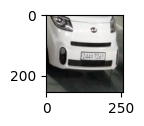

[correct] pred: 1 gt: 1, result: True



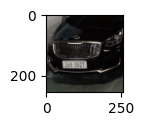

[correct] pred: 1 gt: 1, result: True



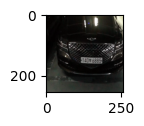

[correct] pred: 1 gt: 1, result: True


cam 58


frame: ./cam/58/DJI_0013_002-018.MP4_snapshot_01.42_[2022.09.05_15.10.33].jpg



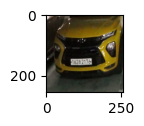

[correct] pred: 1 gt: 1, result: True



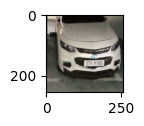

[correct] pred: 1 gt: 1, result: True



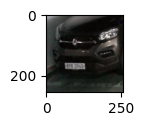

[correct] pred: 1 gt: 1, result: True


cam 57


frame: ./cam/57/DJI_0013_002-018.MP4_snapshot_00.48_[2022.09.05_15.09.30].jpg



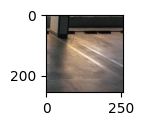

[correct] pred: 0 gt: 0, result: True



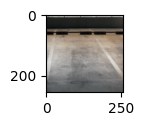

[correct] pred: 0 gt: 0, result: True



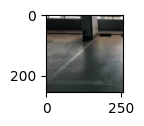

[correct] pred: 0 gt: 0, result: True



In [43]:
result_txt = open(os.path.join(path, 'result.txt'), 'w') # 저장용 텍스트 파일 생성

for cam_id in cam_list.keys():
    msg = '\ncam {}\n'.format(cam_id)
    print(msg)
    result_txt.write(msg)
    
    cam = cam_list[cam_id] # 각 카메라 폴더마다
    
    for image in cam['images']:
        src = cv2.imread(image, cv2.IMREAD_COLOR) # 약 80ms -> 추후 서비스 시 이 부분을 실제 카메라에서 입력되는 frame으로 변경 
        msg = '\nframe: {}\n'.format(image) 
        print(msg)
        result_txt.write(msg)
        for i, bb_points in enumerate(cam['bb_points_list']): # 각 주차면마다 # 한 loop당 약 0.5ms
            gt = cam['gts'][i] # Ground Truth -> 실제 서비스 시에는 없는 정보

            # Patch 추출
            srcPoint = np.float32([bb_points[3], bb_points[2], bb_points[1] , bb_points[0]]) # 변환 전 4개 좌표 
            dstPoint = np.array([[0, 0], [256, 0], [256, 256], [0, 256]], dtype=np.float32) # 변환 후 4개 좌표
            matrix = cv2.getPerspectiveTransform(srcPoint, dstPoint) # Perspective transformation 생성
            patch_img = cv2.warpPerspective(src, matrix, (256, 256)) # 변환

            # 이미지 출력
            plt.figure(figsize=(1, 1))
            plt.imshow(patch_img)
            plt.show()

            # 이미지 전처리
            img_preprocessed = data_transforms['test'](patch_img).to(DEVICE) # 약 0.3ms [3, 256, 256]
            img_preprocessed = img_preprocessed[None, :] # [1, 3, 256, 256]

            # Inference
            output = model(img_preprocessed) # 각 클래스 확률 값 # 약 0.8ms for 1 image
            prediction = output.max(1, keepdim = True)[1] # 예측하는 클래스 번호

            # 결과 비교
            result = prediction.eq(torch.Tensor([gt]).to(DEVICE).view_as(prediction))

            if ~result: # 틀림
                msg = "[incorrect] pred: {} gt: {}, result: {}\n".format(prediction.cpu().numpy()[0][0], gt, result.cpu().numpy()[0][0])  
            else: # 맞음
                msg = "[correct] pred: {} gt: {}, result: {}\n".format(prediction.cpu().numpy()[0][0], gt, result.cpu().numpy()[0][0])

            print(msg)
            result_txt.write(msg)

result_txt.close()

추후 고정된 카메라에서 얻은 frame들을 offline으로 테스트 시 
1. cam 폴더 내에 새로운 폴더를 생성(예를 들어 test_cam)
2. 생성된 폴더 내에 얻은 frame들을 저장
3. annotations.xml 파일에 카메라 라벨링 정보 추가 (annotations.xml 파일 내용 참조)
    - 'cam' 태그를 사용해야 하며 id에 폴더 이름 작성 (test_cam)
    - width, height -> 영상 frame 크기
    - 주차면 개수만큼 라벨링 정보 추가 (polyline or polygon from CVAT 라벨링)
4. 코드 실행

실시간 동작시에는 폴더에서 이미지를 읽어오는 대신 CCTV로부터 들어온 frame을 사용해야 함